In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as plt_image
import matplotlib.image as mpimg

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import TensorBoard
%reload_ext tensorboard
%matplotlib inline

from google.colab import files
from keras.preprocessing import image
import zipfile,os

In [ ]:
# install kaggle
! pip install -q kaggle

from google.colab import files
files.upload()

# create a kagle folder
! mkdir ~/.kaggle

# copy the kaggle.json to folder created
! cp kaggle.json ~/.kaggle/

# permission for the json to act
! chmod 600 ~/.kaggle/kaggle.json

# to list all datasets in kaggle
! kaggle datasets list

! kaggle datasets download -d sandi07/dataset-sampah

Saving archive (1).zip to archive (1).zip
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 398, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
Dataset URL: https://www.kaggle.com/datasets/sandi07/dataset-sampah
License(s): unknown
 68% 17.0M/24.9M [00:00<00:00, 54.5MB/s]
100% 24.9M/24.9M [00:00<00:00, 71.5MB/s]


In [ ]:
local_zip = '/content/dataset-sampah.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/waste')
zip_ref.close()

In [ ]:
os.listdir('/tmp/waste/')

['DATASET']

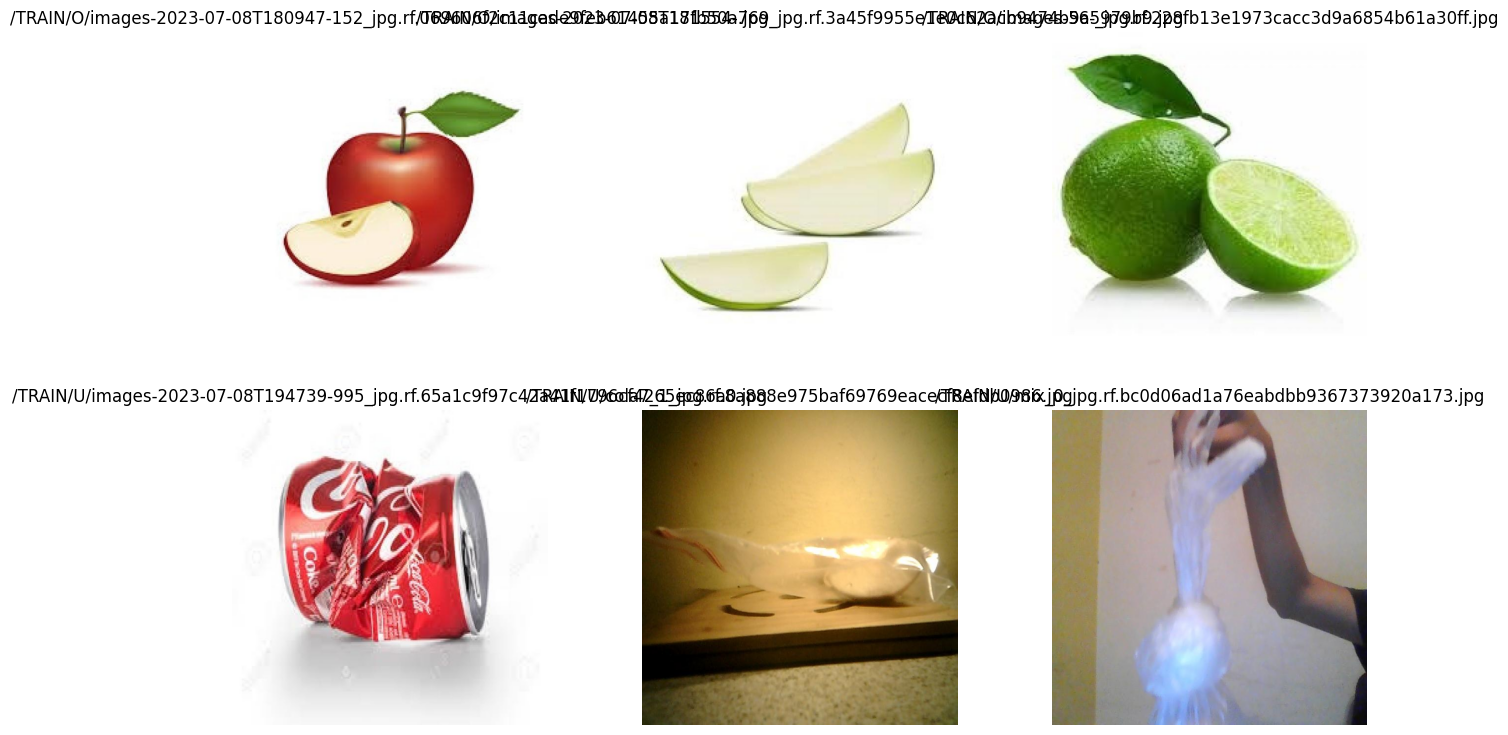

In [ ]:
TOTAL = 3                        # Total Menampilkan Gambar
index = np.random.randint(10)    # Untuk Mengambil Sampel Acak

plt.figure(figsize=(5*TOTAL, 9))

list_organic = [os.path.join('/tmp/waste/DATASET/TRAIN/O', name) for name in os.listdir('/tmp/waste/DATASET/TRAIN/O')[index:index+TOTAL]]
list_non_organic = [os.path.join('/tmp/waste/DATASET/TRAIN/U', name) for name in os.listdir('/tmp/waste/DATASET/TRAIN/U')[index:index+TOTAL]]

for i, path in enumerate(list_organic+list_non_organic):
  plt.subplot(2, TOTAL, i+1)
  plt.axis('off')

  plt.title(path.replace('/tmp/waste/DATASET', ''))
  img = plt_image.imread(path)
  plt.imshow(img)

SAMPAH ORGANIK


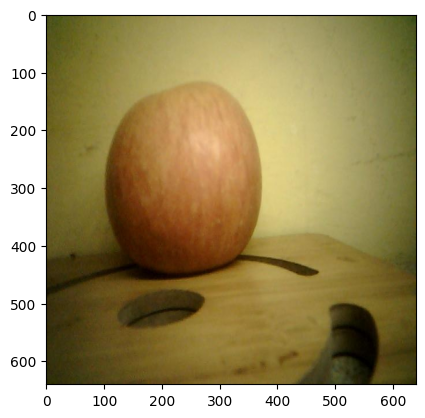

(640, 640, 3)


In [ ]:
print('SAMPAH ORGANIK')
preview = plt_image.imread('/tmp/waste/DATASET/TRAIN/O/Arduino2_10_jpg.rf.baec2ef0c1eb0e255fc5fa64313e5066.jpg')
plt.imshow(preview)
plt.show()
print(preview.shape)

SAMPAH NON-ORGANIK


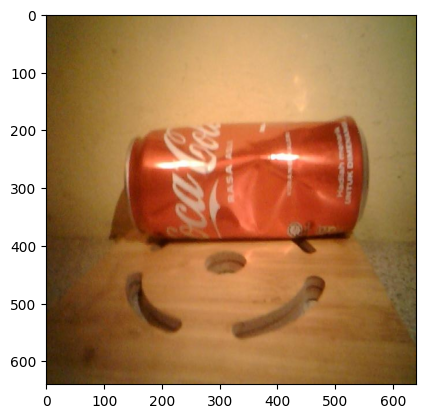

(640, 640, 3)


In [ ]:
print('SAMPAH NON-ORGANIK')
preview = plt_image.imread('/tmp/waste/DATASET/TRAIN/U/cola09_0_jpg.rf.23f0a4339424a1584c496aeddc717970.jpg')
plt.imshow(preview)
plt.show()
print(preview.shape)

In [ ]:
train_dir = '/tmp/waste/DATASET/TRAIN'
validation_dir = '/tmp/waste/DATASET/TEST'

In [ ]:
# melihat struktur data
os.listdir('/tmp/waste/DATASET/TRAIN/')
os.listdir('/tmp/waste/DATASET/TEST/')

['U', 'O']

In [ ]:
print('Banyaknya Data Train\nOrganic : ')
print(len(os.listdir('/tmp/waste/DATASET/TRAIN/O')))
print('Non-organic : ')
print(len(os.listdir('/tmp/waste/DATASET/TRAIN/U')))

print('\nBanyaknya Data Validation\nOrganic : ')
print(len(os.listdir('/tmp/waste/DATASET/TEST/O')))
print('Non-organic : ')
print(len(os.listdir('/tmp/waste/DATASET/TEST/U')))

Banyaknya Data Train
Organic : 
521
Non-organic : 
283

Banyaknya Data Validation
Organic : 
59
Non-organic : 
35


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              target_size=(150, 150),
                                                              batch_size=32,
                                                              class_mode='binary')

Found 804 images belonging to 2 classes.
Found 94 images belonging to 2 classes.


In [ ]:
# Menginisialisasi Callback
class stopTraining(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if((logs.get('accuracy') > 0.81) and (logs.get('val_accuracy') > 0.81)):
      print("\nStop Training because the accuracy and val_accuracy has exceeded 80%")
      self.model.stop_training = True

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 32)        0

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 32)        0

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // train_generator.batch_size,
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // validation_generator.batch_size)

# Evaluation using validation data (as a proxy for test data)
loss, accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f'Validation Accuracy: {accuracy:.2f}')

Epoch 1/30
25/25 [==============================] - 27s 511ms/step - loss: 0.6582 - accuracy: 0.6438 - val_loss: 0.6756 - val_accuracy: 0.6250
Epoch 2/30
25/25 [==============================] - 6s 226ms/step - loss: 0.6351 - accuracy: 0.6619 - val_loss: 0.4979 - val_accuracy: 0.8906
Epoch 3/30
25/25 [==============================] - 7s 270ms/step - loss: 0.5401 - accuracy: 0.7189 - val_loss: 0.3890 - val_accuracy: 0.8281
Epoch 4/30
25/25 [==============================] - 7s 269ms/step - loss: 0.4698 - accuracy: 0.7578 - val_loss: 0.3815 - val_accuracy: 0.7812
Epoch 5/30
25/25 [==============================] - 6s 228ms/step - loss: 0.4982 - accuracy: 0.7254 - val_loss: 0.6739 - val_accuracy: 0.6250
Epoch 6/30
25/25 [==============================] - 6s 229ms/step - loss: 0.5255 - accuracy: 0.7642 - val_loss: 0.2979 - val_accuracy: 0.8594
Epoch 7/30
25/25 [==============================] - 7s 282ms/step - loss: 0.4558 - accuracy: 0.7642 - val_loss: 0.4734 - val_accuracy: 0.6562
Epoch

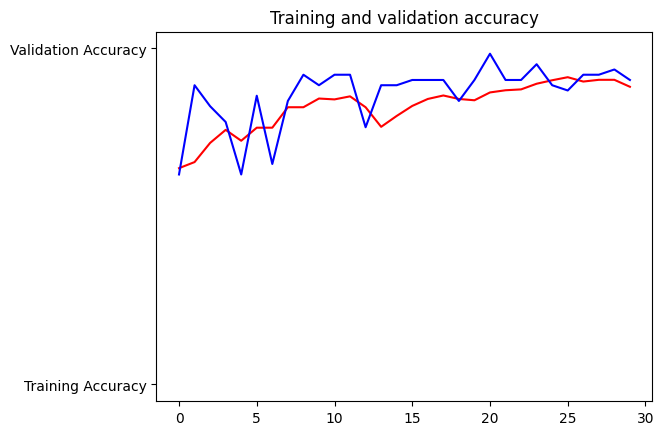

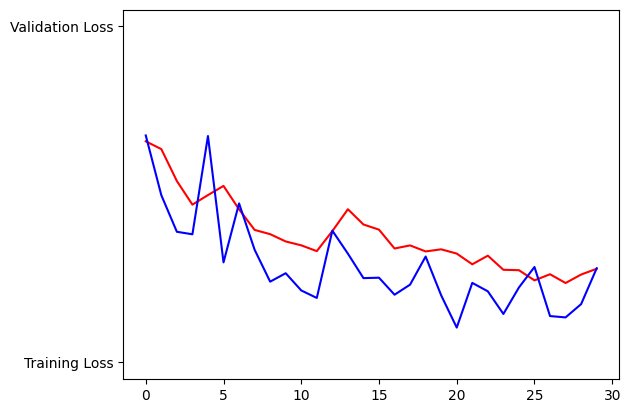

In [ ]:

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs


plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")


plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

Saving cola2_19_jpg.rf.c5ae424b02230095ad43d6bec40e20e9.jpg to cola2_19_jpg.rf.c5ae424b02230095ad43d6bec40e20e9.jpg
Saving download-24-_jpg.rf.a21bf39031371a3b9636cb105537486f.jpg to download-24-_jpg.rf.a21bf39031371a3b9636cb105537486f.jpg
Saving download-41-_jpg.rf.8243a5debc9d209aa00ba7fd26d12474.jpg to download-41-_jpg.rf.8243a5debc9d209aa00ba7fd26d12474.jpg
Saving images-2023-07-08T165551-249_jpg.rf.844635def037f03de7523776fbb759f4.jpg to images-2023-07-08T165551-249_jpg.rf.844635def037f03de7523776fbb759f4.jpg
1/1 [==============================] - 0s 385ms/step
cola2_19_jpg.rf.c5ae424b02230095ad43d6bec40e20e9.jpg
SAMPAH ORGANIK
1/1 [==============================] - 0s 17ms/step
download-24-_jpg.rf.a21bf39031371a3b9636cb105537486f.jpg
SAMPAH ORGANIK
1/1 [==============================] - 0s 16ms/step
download-41-_jpg.rf.8243a5debc9d209aa00ba7fd26d12474.jpg
SAMPAH ORGANIK
1/1 [==============================] - 0s 17ms/step
images-2023-07-08T165551-249_jpg.rf.844635def037f03de752377

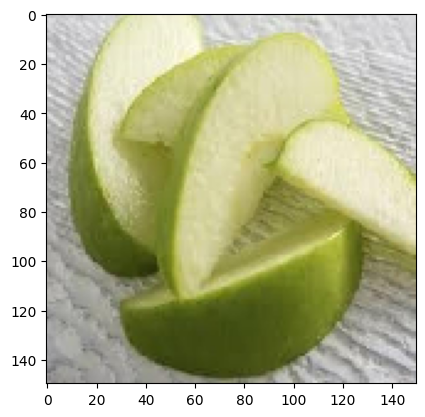

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  # predicting image
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)

  print(fn)
  if classes==0:
    print('SAMPAH ORGANIK')
  else:
    print('SAMPAH NON ORGANIK')

In [ ]:
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model

# Muat model dari file .h5
model = load_model('model.h5')

# Buat converter untuk model
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Konversi model ke format TensorFlow Lite
tflite_model = converter.convert()

# Simpan model TensorFlow Lite ke file
with open('kocak.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model telah berhasil dikonversi ke format TensorFlow Lite dan disimpan dalam file model.tflite")


Model telah berhasil dikonversi ke format TensorFlow Lite dan disimpan dalam file model.tflite
